# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
#data review
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [8]:
display(df_reviews[df_reviews.isnull().any(axis=1)])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [9]:
df_reviews = df_reviews.dropna().copy()

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

## EDA

Let's check the number of movies and reviews over years.

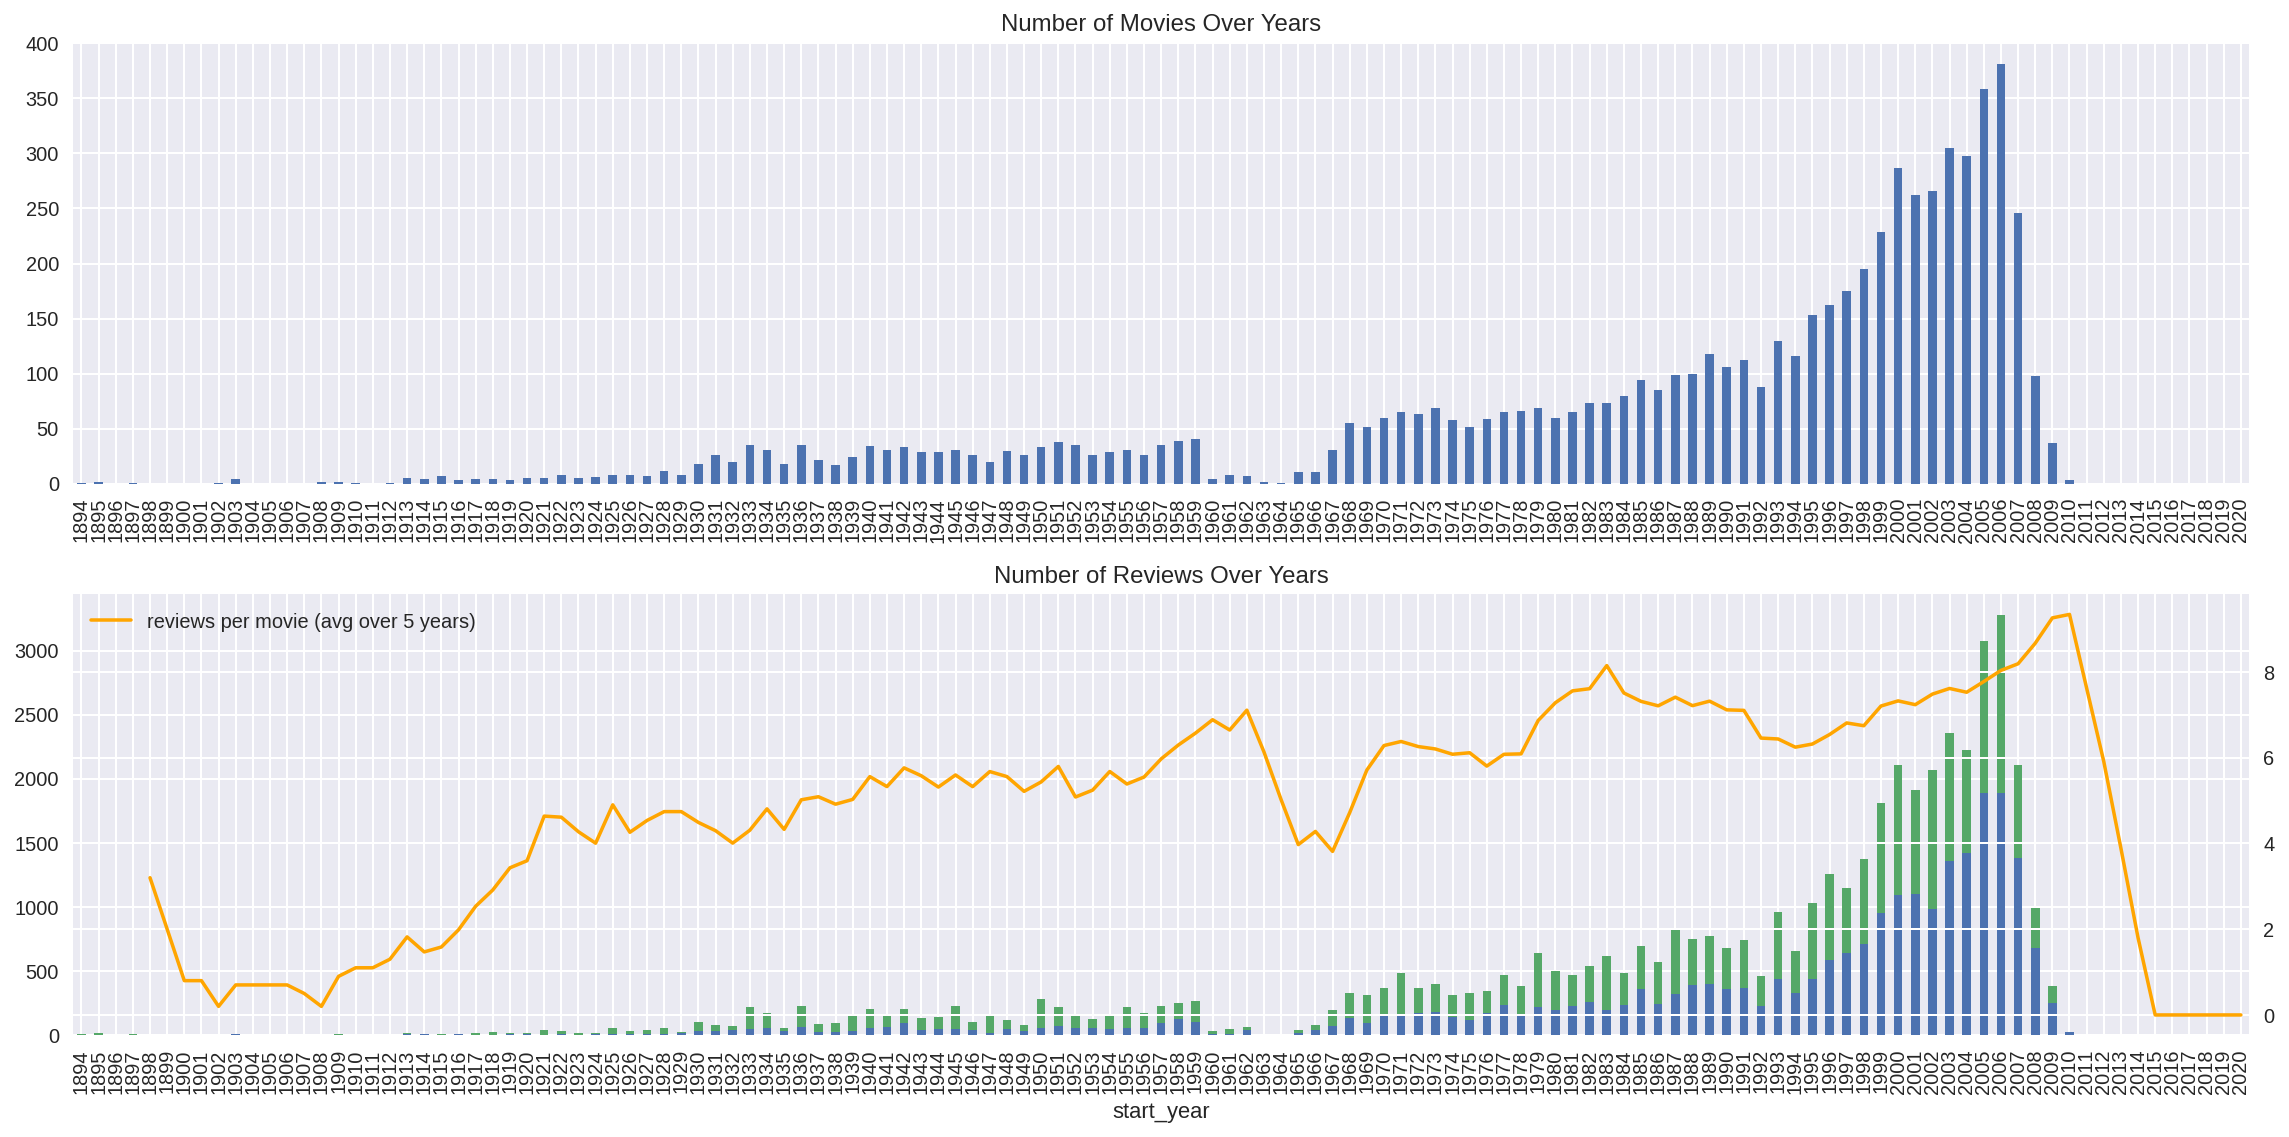

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

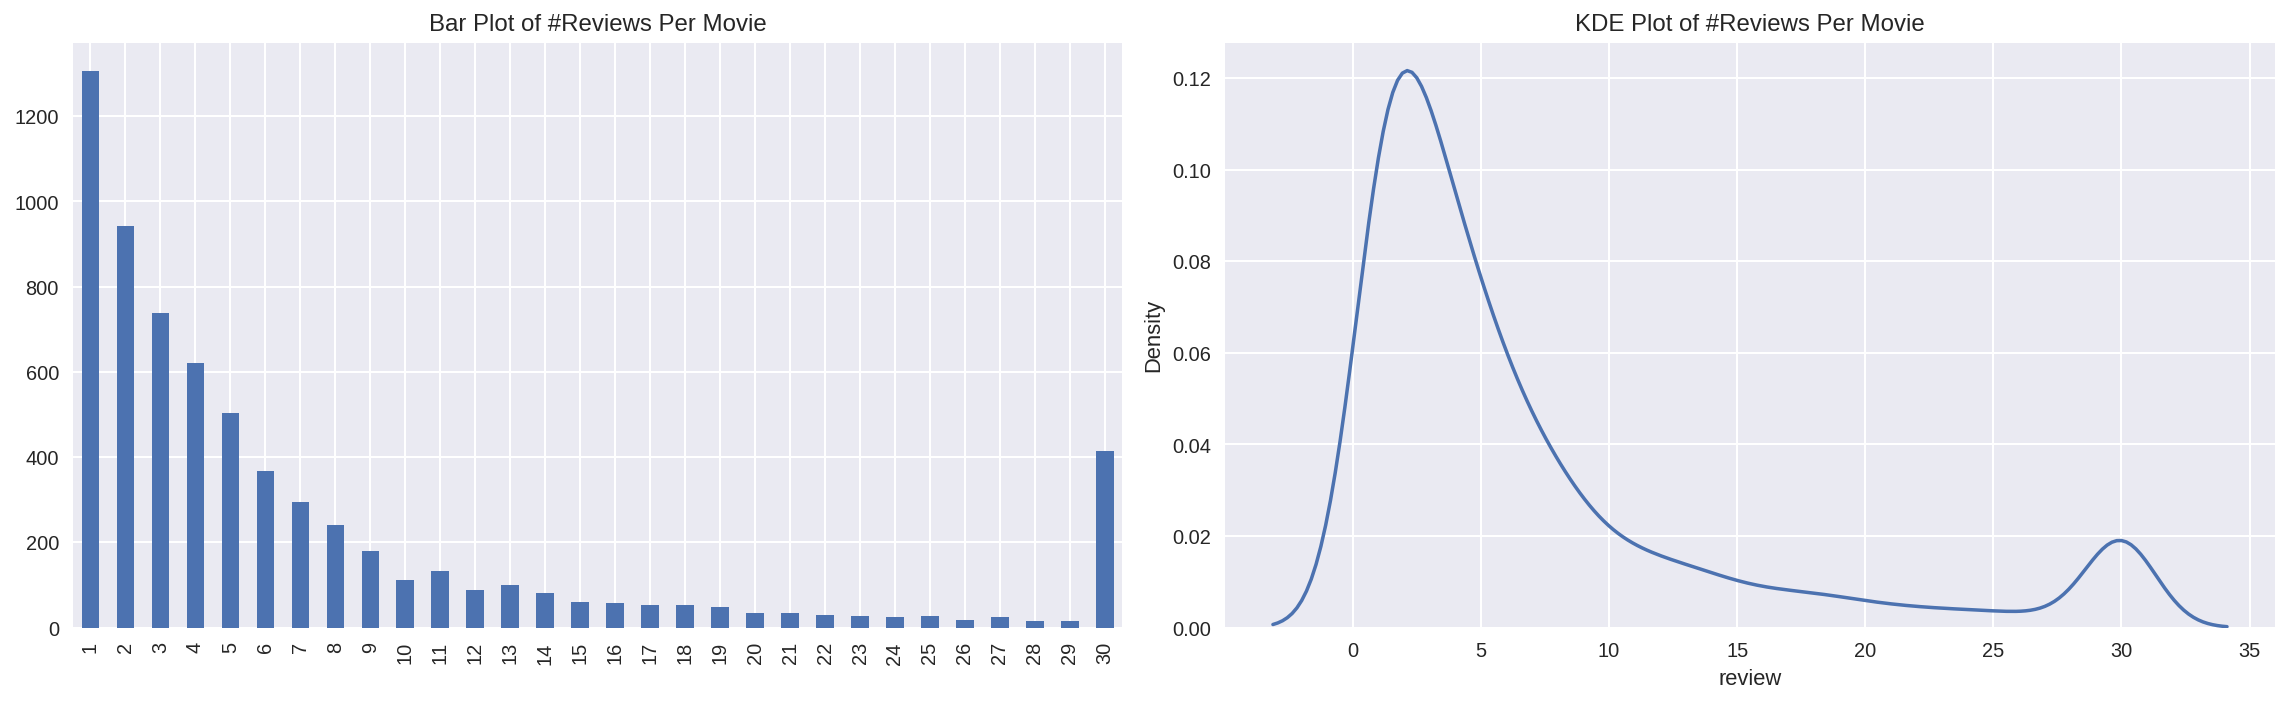

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

**Discoveries**

Based on the aforementioned top 2 diagrams, a significant upward trajectory in the quantity of movie reviews can be observed, commencing in the early 1990s. This surge can be attributed to the increasing accessibility and affordability of the VHS format, as well as the introduction of DVDs into the market in 1996.

Examining the bottom 2 charts, we are presented with the distribution of reviews per movie. It is evident that a substantial majority of movies have received less than 5 reviews, with a notable exception of one movie that garnered 30 reviews. This particular distribution may result in an imbalance within the classes or other forms of skewness, depending on the nature of the reviews (positive or negative).

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

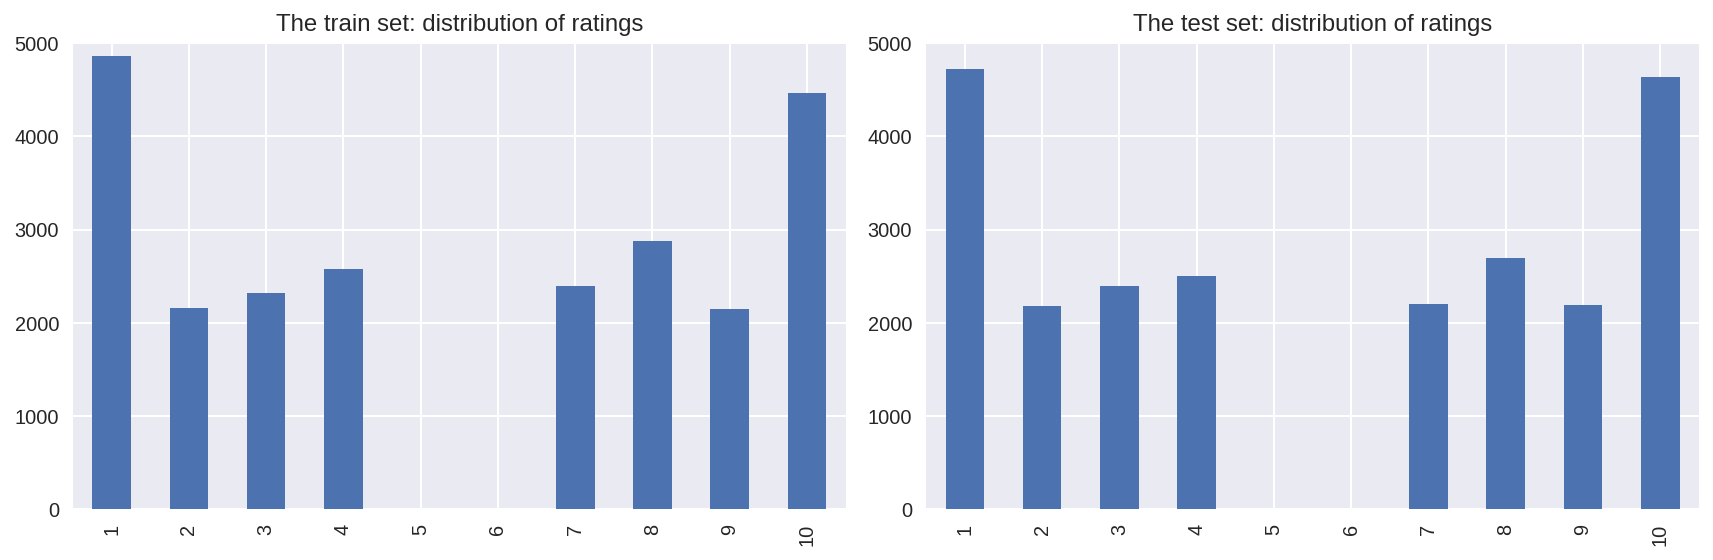

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [14]:
df_reviews.query('ds_part == "train"')['pos'].value_counts() # 50.1% negative

0    11912
1    11884
Name: pos, dtype: int64

In [15]:
df_reviews.query('ds_part == "test"')['pos'].value_counts() # 50.2% negative

0    11803
1    11730
Name: pos, dtype: int64

Distribution of negative and positive reviews over the years for two parts of the dataset

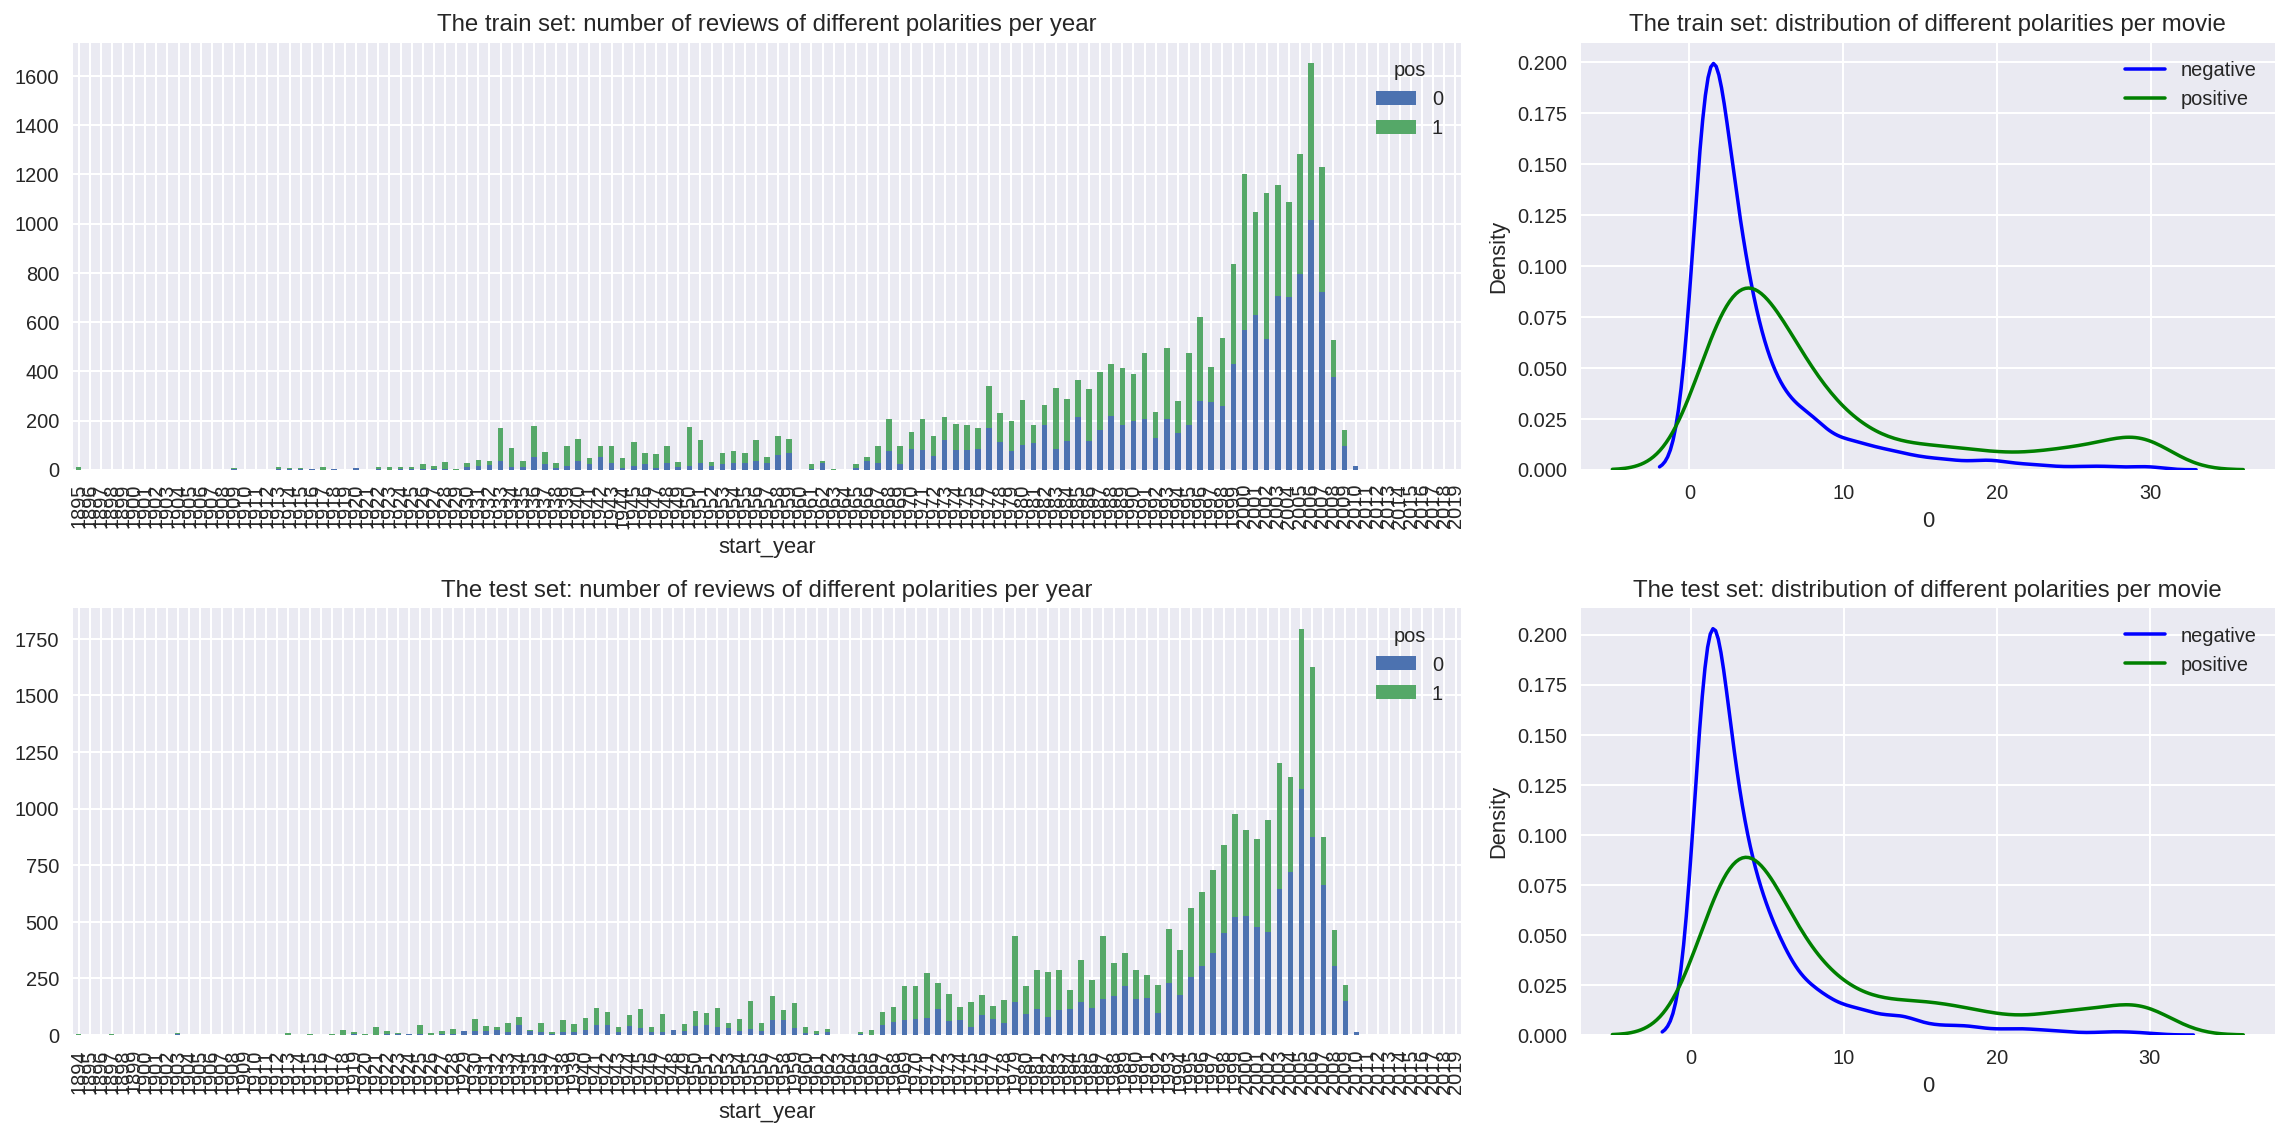

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**Discoveries**

Examining the rating distributions of our train and test sets enables us to confirm the anticipated similarities in both the distribution of ratings and the corresponding polarities.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data and made some interesting observations!

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
def normalize(review):
    pattern = r"[^a-zA-Z' ]"
    review = re.sub(pattern, '', review)
    
    return " ".join(review.split())


df_reviews['review_norm'] = df_reviews['review'].apply(normalize)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Normalization looks good
</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [20]:
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

In [21]:
random_state = 12345 # constant random_state value to apply to all models

In [22]:
target = "pos"
features = list(set(df_reviews_train.columns)-set([target])-set(["review"]))

In [23]:
X_train, X_test, y_train, y_test =  df_reviews_train[features], df_reviews_test[features], train_target, test_target


## Working with models

### Model 0 - Constant

In [24]:
from sklearn.dummy import DummyClassifier

In [25]:
strategies = ['most_frequent', 'stratified', 'uniform', 'constant'] 
  
test_scores = []  
for s in strategies: 
    if s =='constant': 
        dummy_model = DummyClassifier(strategy = s, random_state = random_state, constant = 0) 
    else: 
        dummy_model = DummyClassifier(strategy = s, random_state = random_state) 
    dummy_model.fit(corpus_train, train_target) 
    score = dummy_model.score(corpus_test, test_target) 
    test_scores.append(score)

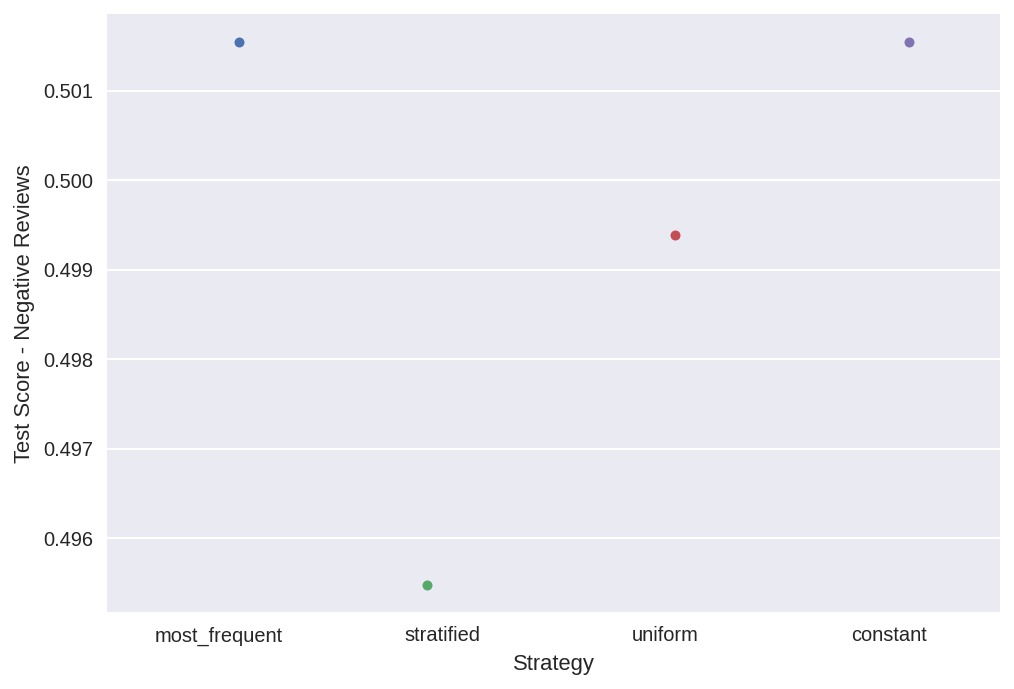

In [26]:
ax = sns.stripplot(strategies, test_scores); 
ax.set(xlabel ='Strategy', ylabel ='Test Score - Negative Reviews') 
plt.show() 

# achieved the same results while leveraging the lemmatized/transformed train/test corpus and their respective features

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [ ]:

import nltk
nltk.download('all')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [28]:
lemmatizer  = WordNetLemmatizer() 

In [29]:
def lemmatize(review):

    tokens = word_tokenize(review.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return " ".join(lemmas)

In [30]:
lr_corpus_train = corpus_train.apply(lemmatize) # applying the nltk lemmatize function to our normalized review data

lr_corpus_test = corpus_test.apply(lemmatize) # applying the nltk lemmatize function to our normalized review data

In [31]:
from spacy.lang.de.stop_words import STOP_WORDS

# stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words = list(STOP_WORDS))

In [32]:
tf_idf = count_tf_idf.fit_transform(lr_corpus_train) # transforming our text corpus via TfidVectorizer

In [33]:
train_features_1 = tf_idf # training feature
test_features_1 = count_tf_idf.transform(lr_corpus_test) # test feature

In [34]:
model_1 = LogisticRegression(random_state=random_state)
model_1.fit(train_features_1, train_target) # model training

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


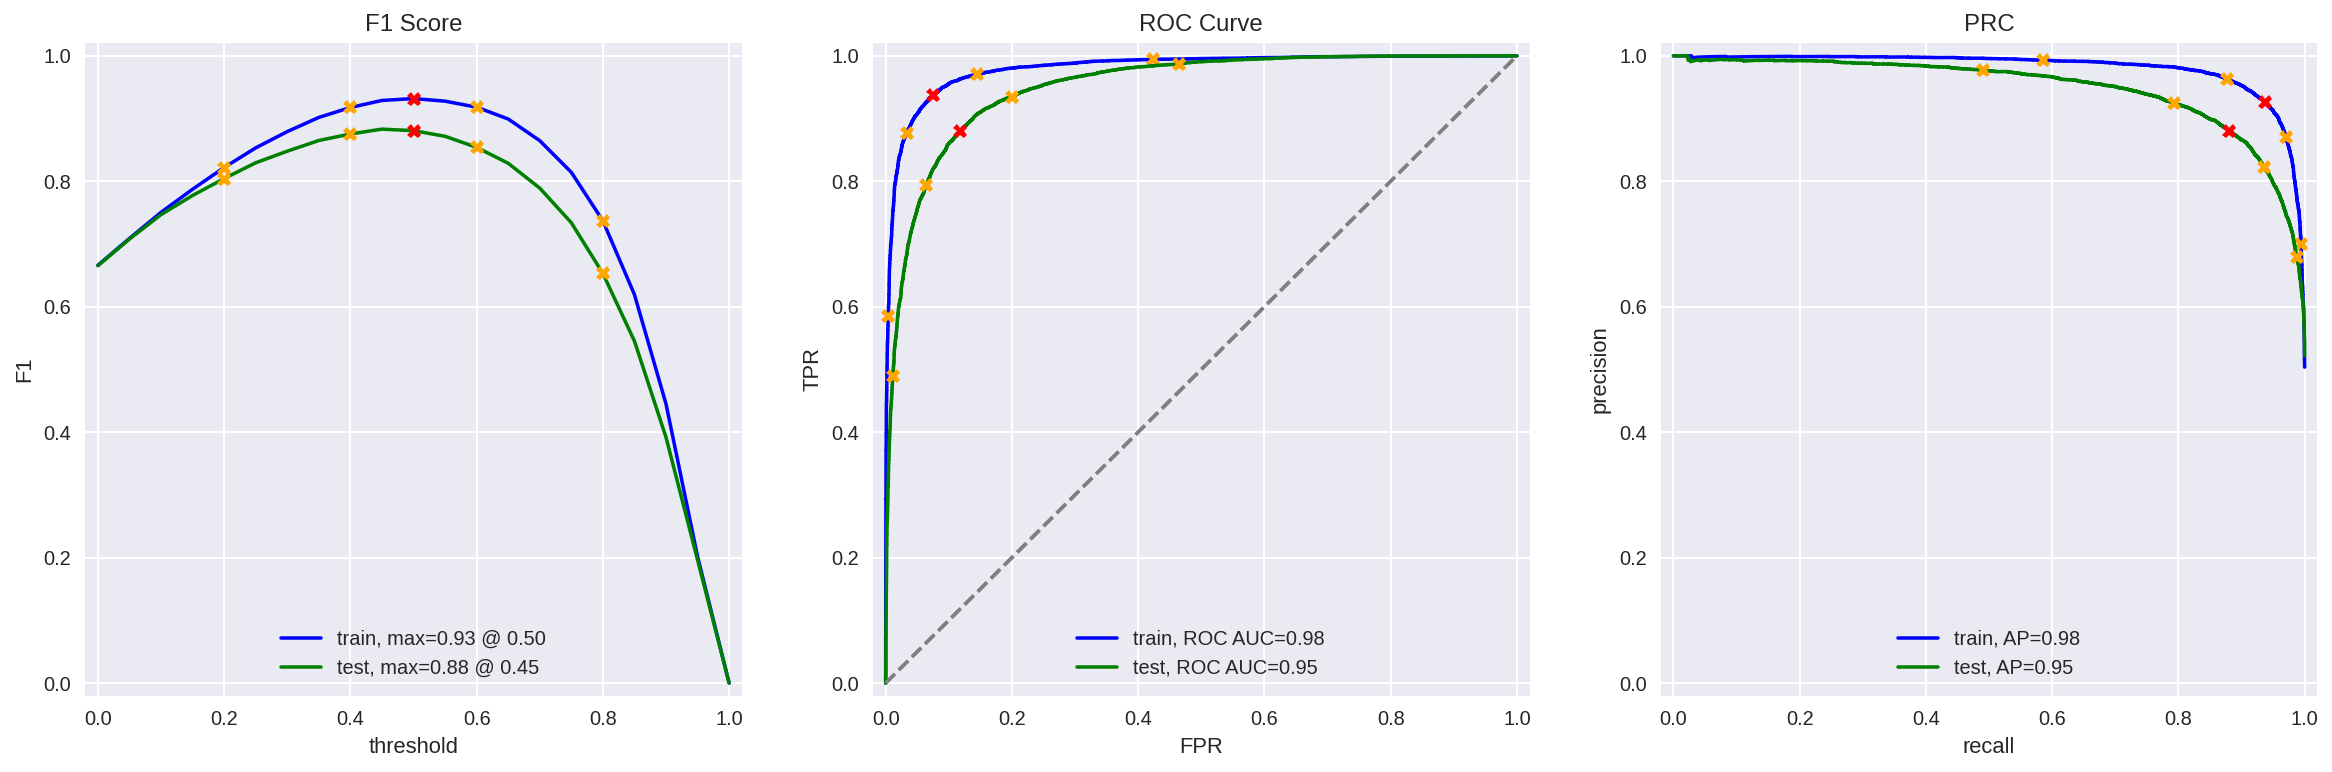

In [35]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

In [36]:
model_1_predict = model_1.predict(test_features_1)

print(classification_report(test_target, model_1_predict))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11730

    accuracy                           0.88     23533
   macro avg       0.88      0.88      0.88     23533
weighted avg       0.88      0.88      0.88     23533



### Model 3 - spaCy, TF-IDF and LR

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.add_pipe('sentencizer')

In [ ]:
def text_preprocessing_spacy(review):
    
    doc = nlp(review.lower())
    # tokens = [token.lemma_ for token in doc if not token.is_stop]
    lemmas = []    
    for token in doc:
        lemmas.append(token.lemma_)
    # lemmas = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    
    return ' '.join(lemmas)

In [ ]:
lr_corpus_train_spacy = corpus_train.apply(text_preprocessing_spacy) # applying the spaCy lemmatize/processing function to our normalized review data

lr_corpus_test_spacy = corpus_test.apply(text_preprocessing_spacy) # applying the spaCy lemmatize/processing function to our normalized review data

In [ ]:
count_tf_idf_3 = TfidfVectorizer(stop_words = list(STOP_WORDS))

train_features_spacy = count_tf_idf_3.fit_transform(lr_corpus_train_spacy) # 
test_features_spacy = count_tf_idf_3.transform(lr_corpus_test_spacy)

In [ ]:
model_3 = LogisticRegression(random_state=random_state)
model_3.fit(train_features_spacy, train_target)

In [ ]:
evaluate_model(model_3, train_features_spacy, train_target, test_features_spacy, test_target)

In [ ]:
model_3_predict = model_3.predict(test_features_spacy)

print(classification_report(test_target, model_3_predict))

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [44]:
from lightgbm import LGBMClassifier

In [45]:
model_4 = LGBMClassifier(random_state=random_state)
model_4.fit(train_features_spacy, train_target) # model training

LGBMClassifier(random_state=12345)

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


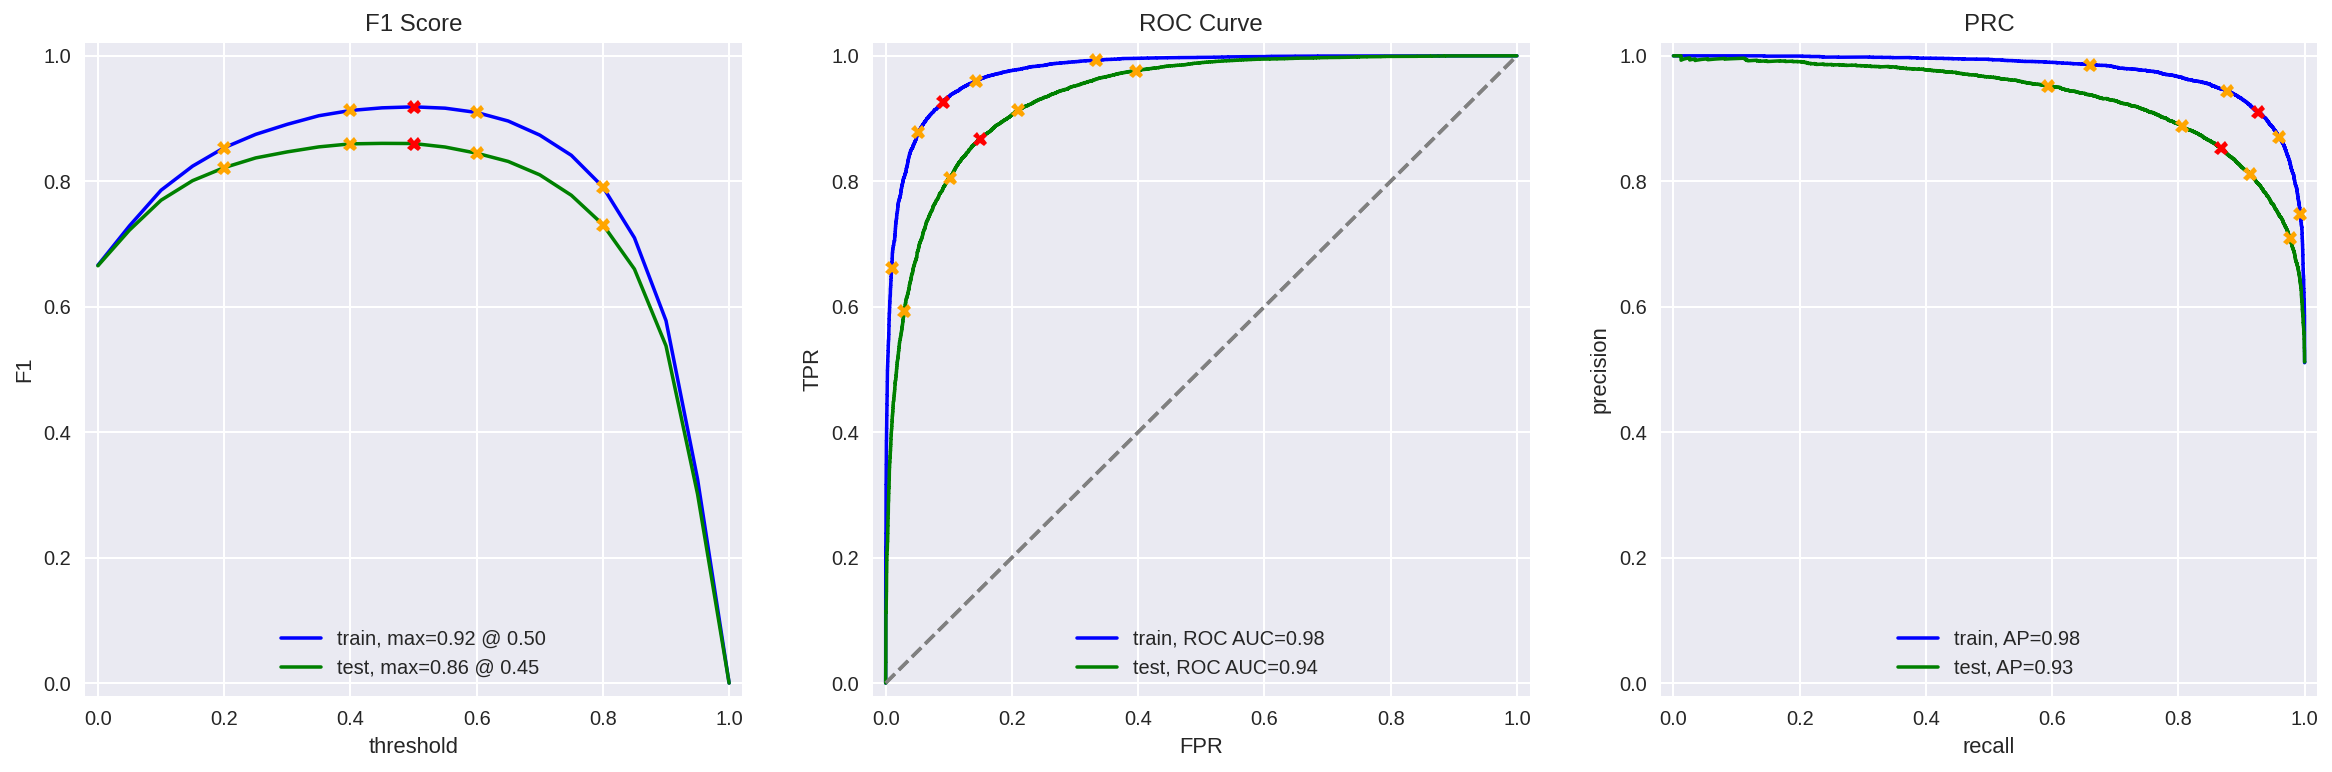

In [46]:
evaluate_model(model_4, train_features_spacy, train_target, test_features_spacy, test_target) # evaluation

In [47]:
model_4_predict = model_4.predict(test_features_spacy)

print(classification_report(test_target, model_4_predict))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     11803
           1       0.85      0.87      0.86     11730

    accuracy                           0.86     23533
   macro avg       0.86      0.86      0.86     23533
weighted avg       0.86      0.86      0.86     23533



<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent, you successfully vectorized text data using TF-IDF and trained a couple of different models using the vector data. It's nice that you applied lemmatization!

</div>

###  Model 9 - BERT

**The completion of this task will be postponed until a later date because of limitations with the GPU.**

<div class="alert alert-success">
<b>Reviewer's comment</b>

You can try running it on google colab by the way: it's a platform which gives you access to jupyter notebooks with a GPU for free with some limitations

</div>

In [48]:
import torch
import transformers

In [49]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [51]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [53]:
## Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [55]:
# model_9 = LogisticRegression()
# best_bert_model, best_bert_f1, best_bert_time = build_model(model_9, train_features_9, train_y, 
#                                                         test_features_9, test_y,
#                                                         hyperparameters={'C' : [.01, .1, 1, 10]}, 
#                 scoring='f1_weighted', cv=5)

In [ ]:
# # test set- using bert
# best_bert_f1

In [ ]:
# evaluate_model(best_bert_model, train_features_9, train_y, test_features_9, test_y)

In [ ]:
# model_results_df = pd.DataFrame({'model': ['LogisticRegression-NLTK', 'LogisticRegression-Spacy', 'LGBMClassifier', 
                                          'LogisticRegression-BERT'],
              'best_f1': [best_lr_f1, best_lr_spacy_f1, best_lgbm_f1, best_bert_f1],
              'train_time': [best_lr_time, best_lr_spacy_time, best_lgbm_time, best_bert_time]})

In [ ]:
# model_results_df

The DummyClassifier, as anticipated, yields an F1 score of 50%, which is equivalent to the outcome of flipping an unbiased coin.

When comparing the LogisticRegression models with NLTK and Spacy for preprocessing, the model utilizing NLTK preprocessing emerges as the superior one, achieving the highest f1 score of 88%. Moreover, the preprocessing time for NLTK was 9 times faster compared to Spacy. However, during training, the Spacy preprocessed model finished approximately 8 seconds earlier.

Both models underwent training using 5 fold cross-validation with hyperparameter tuning on the C parameter.

The LightGBM model, on the other hand, exhibited a lower f1 score and required over an hour to complete the training process.

As for the BERT encodings on GPU, each took around 20 minutes for both the training and test reviews. The LogisticRegression model built upon this performed the worst, yielding an f1 score of 86.4%.

## My Reviews

In [62]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",Well I was bored and felt asleep in the middle...
2,I was really fascinated with the movie,I was really fascinated with the movie
3,Even the actors looked really old and disinter...,Even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,I didn't expect the reboot to be so good Write...
5,"The movie had its upsides and downsides, but I...",The movie had its upsides and downsides but I ...
6,What a rotten attempt at a comedy. Not a singl...,What a rotten attempt at a comedy Not a single...
7,Launching on Netflix was a brave move & I real...,Launching on Netflix was a brave move I really...


### Model 1

In [63]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  I did not simply like it not my kind of movie
0.31:  Well I was bored and felt asleep in the middle of the movie
0.59:  I was really fascinated with the movie
0.20:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.36:  I didn't expect the reboot to be so good Writers really cared about the source material
0.60:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.10:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.83:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


### Model 4

In [66]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  I did not simply like it not my kind of movie
0.19:  Well I was bored and felt asleep in the middle of the movie
0.51:  I was really fascinated with the movie
0.15:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.20:  I didn't expect the reboot to be so good Writers really cared about the source material
0.67:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.02:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.87:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


### Model 3

In [68]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = count_tf_idf_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  I did not simply like it not my kind of movie
0.19:  Well I was bored and felt asleep in the middle of the movie
0.51:  I was really fascinated with the movie
0.15:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.20:  I didn't expect the reboot to be so good Writers really cared about the source material
0.67:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.02:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.87:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


### Model 9

In [ ]:
# texts = my_reviews['review_norm']

# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were applied to new reviews correctly

</div>

## Conclusions

**`General`**

- We instantiated a DataFrame containing over 40k+ rows and 15+ columns, with various data types. Our objective was to apply machine learning techniques to a collection of reviews, specifically from IMDB. To focus on this task, we set aside a large number of columns and concentrated on three specific ones:

    - `review`: the text of the review
    - `pos`: the target variable, with '0' indicating a negative review and '1' indicating a positive review
    - `ds_part`: indicating whether the data belongs to the training or testing set

- By conducting exploratory data analysis (EDA) and utilizing visualizations, we gained an understanding of the data structure, particularly the distribution of our target variable and any imbalances present. Additionally, we discovered insights such as the frequency of reviews per movie. This allowed us to form an initial perspective on the polarity of our target variable and the distribution of ratings.

Upon initial inspection, the DataFrame did not exhibit many errors or require extensive clean-up. We only encountered a small number of N/A values, which we removed due to their negligible impact on the exercise (approximately 2 or 3 rows).

- Before commencing the initialization of our models, we commence by establishing the approach we will employ to 'normalize' our features (reviews) by eliminating digits, punctuation marks, and other similar elements. This preliminary cleansing process lays the foundation for us to divide the data and generate the necessary train/test text corpus, which will be subsequently utilized in our modeling.

- To ensure the adequacy of our LR/LGBM models, we developed a dummy model for benchmarking purposes. This allowed us to compare and confirm that our LR/LGBM models outperformed the dummy model.

- By utilizing tokenization and lemmatization techniques through NLTK and spaCy, we achieved F1 scores that consistently surpassed our target value of `0.85` across all three models. Among these models, the LinearRegression model that employed both NLTK and spaCy processing for tokenization/lemmatization of our review corpus attained the highest F1 score. The scores for each model were as follows:

    - `LR + NLTK`: 0.88

    - `LR + spaCy`: 0.88

    - `LGBM + spaCy`: 0.86

- Remarkably, we were able to achieve these scores without the necessity of fine-tuning or searching for optimal hyperparameters.

- Lastly, for the purpose of this exercise, we made the decision not to execute the BERT model. This choice was made due to the fact that we were able to attain the required scores through the LR/LGBM models, and running the BERT model would have entailed an extensive computational time.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice summary!

</div>

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions